In [1]:
from foundry.util.runtime import setup
setup()

In [2]:
import foundry.random
import foundry.numpy as npx
import foundry.train

import foundry.core as F
import flax.linen as nn
import flax.linen.activation as activations

import math
import jax
import optax
import foundry.train.console

from typing import Sequence

In [3]:
import wandb
api = wandb.Api()
artifact = api.artifact("dpfrommer-projects/image-diffusion/mnist-ddpm:v3")
checkpoint_url = artifact.get_entry("checkpoint.zarr.zip").ref
import foundry.util.serialize
checkpoint = foundry.util.serialize.load(checkpoint_url)

In [4]:
import jax
model = checkpoint.config.create()
normalizer = checkpoint.normalizer
schedule = checkpoint.schedule
vars = checkpoint.vars
train_data, test_data = checkpoint.create_data()
train_data = jax.vmap(normalizer.normalize)(train_data.as_pytree())
test_data = jax.vmap(normalizer.normalize)(test_data.as_pytree())

In [ ]:
from latent_embed import train_embedding
encode, decode = train_embedding(train_data, mode="tsne")

In [ ]:
projections = F.vmap(encode)(test_data)

NameError: name 'ae' is not defined

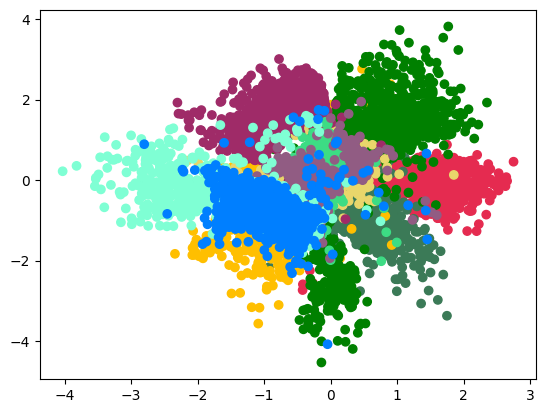

In [ ]:
import matplotlib.pyplot as plt

color_map = {
    0: "#E52B50",
    1: "#9F2B68",
    2: "#3B7A57",
    3: "#3DDC84",
    4: "#FFBF00",
    5: "#915C83",
    6: "#008000",
    7: "#7FFFD4",
    8: "#E9D66B",
    9: "#007FFF",
}
colors = [color_map[label.item()] for label in test_data.label]
plt.scatter(projections[:, 0], projections[:, 1], c=colors)

In [ ]:
from foundry.train.reporting import Image

X, Y = npx.meshgrid(
    npx.linspace(-4, 4, 10),
    npx.linspace(-4, 4, 10),
)
Z = npx.stack((X,Y), axis=-1)
# (row, col, height, width, channel)
images = F.vmap(F.vmap(decode))(Z)
# (row, height, col, width, channel)
images = npx.permute_dims(images, (0, 2, 1, 3, 4))
Image(images.reshape((images.shape[0]*images.shape[1], images.shape[2]*images.shape[3], 1)))

In [ ]:
import foundry.random
zs = npx.stack(npx.meshgrid(
    npx.linspace(-3.5, 3.5, 48),
    npx.linspace(-3.5, 3.5, 48),
), axis=-1).reshape((-1, 2))

@F.jit
def generate(z, rng_key):
    cond = decode(z)
    cond = normalizer.map(lambda x: x.cond).normalize(cond)
    def denoiser(rng_key, x, t):
        return model.apply(vars, x, t, cond=cond)
    sample = schedule.sample(rng_key, denoiser, npx.zeros(test_data.data[0].shape))
    return cond, sample
conds, pixels = F.vmap(generate)(zs, foundry.random.split(foundry.random.key(42), zs.shape[0]))

In [ ]:
import foundry.diffusion.nonparametric as nonparametric

@F.jit
def reference_denoiser(cond, rng_key, x, t):
    return nonparametric.nw_cond_diffuser(cond, (test_data.cond, test_data.data), schedule, 
        nonparametric.log_gaussian_kernel, 0.01
    )(rng_key, x, t)

@F.jit
def eval(rng_key, cond, x, t, vars):
    x_noised, _, _ = schedule.add_noise(rng_key, x, t)
    x_denoised = reference_denoiser(cond, rng_key, x_noised, t)
    x_model = model.apply(vars, x_noised, t, cond=cond)
    return npx.mean(npx.square(x_model - x_denoised))

errors = F.vmap(eval, in_axes=(0, 0, 0, None, None))(
    foundry.random.split(foundry.random.key(42), conds.shape[0]),
    conds, pixels, schedule.num_steps // 2,
    vars
)

2024-11-07 13:14:20.627349: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 4s:

  %multiply.55 = f32[8920,28,28,1]{3,2,1,0} multiply(f32[8920,28,28,1]{3,2,1,0} %constant.370, f32[8920,28,28,1]{3,2,1,0} %broadcast.415), metadata={op_name="jit(eval)/jit(main)/jit(reference_denoiser)/jit(diffuser)/mul" source_file="/home/daniel/Documents/code/foundry/packages/models/src/foundry/diffusion/nonparametric.py" source_line=58}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-11-07 13:14:31.032582: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 14.405299296s
Constant

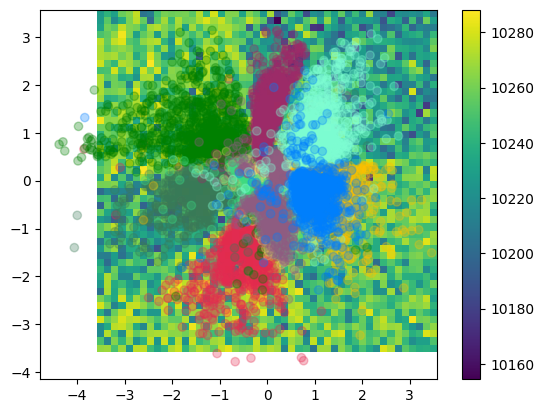

In [ ]:
plt.pcolormesh(
    zs[:,0].reshape((48, 48)),
    zs[:,1].reshape((48, 48)),
    errors.reshape((48, 48))
)
plt.colorbar()
plt.scatter(projections[:, 0], projections[:, 1], c=colors, alpha=0.3)
plt.show()